# Exercise 1
Retention is one of the most important indicators in a company. Your task is to write a function that will count the retention of players (by days from the date of registration of the player). The function must be written in Python. You can test the  function both on the full dataset and on a part (sample) of data.

Importing all the necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The preliminary review showed that the data is displayed incorrectly, separated by a semicolon, so when reading, we specify the appropriate separator.

In [2]:
reg_data = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/djfKmxc-2gbpXA', sep=';')
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


The data is displayed correctly. The time and date are in Unix timestamp format, that is, in seconds since midnight, January 1, 1970 (UTC). Let's look at the size of the existing dataset:

In [4]:
reg_data.shape

(1000000, 2)

Let's take a look at more details about the loaded data:

In [5]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


We can see that there are no missing values ​​in the table, however, the data type for the registration date and time is integer int64, we'll have to correct this.

Determine how many user IDs are unique:

In [6]:
reg_data.uid.nunique()

1000000

All numbers are unique.
Let's convert the column with the registration date to the format we need, discard the time, since we are only interested in the registration date.

In [7]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'],unit='s').dt.date
reg_data.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


Let's read the data from the second dataset like we did with the first:

In [8]:
auth_data = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/L8OYCyyrvNQlUA', sep=';')
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
auth_data.shape

(9601013, 2)

The second dataset contains information about user logins to the game, therefore it has much more volume.

In [10]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Let's take look at the number of missing values:

In [11]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

We will also convert a column with the entry time to the date format:

In [12]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'],unit='s').dt.date
auth_data.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


Before merging, we check that the number of unique uids in both tables is the same

In [13]:
auth_data.uid.nunique() - reg_data.uid.nunique()

0

All right. Otherwise, we could encounter a situation in which the user registered, but did not log in the game, or other kinds of errors in registration and user accounting.

We combine datasets into one dataframe by user id, we take a larger dataset as a basis, use left join when attaching a dataset with the user registration date to it.

In [14]:
df = auth_data.merge(reg_data, how='left', on='uid')
df.head()

,auth_ts,uid,reg_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22


We check that the data was not lost as a result of the merging:

In [15]:
df.shape

(9601013, 3)

Let's introduce an additional column showing how many days have passed from the moment the player registered to the specific entry into the game.

In [16]:
df['retention_day'] = (df['auth_ts'] - df['reg_ts']).dt.days
df.head()

,auth_ts,uid,reg_ts,retention_day
0,1998-11-18,1,1998-11-18,0
1,1999-07-22,2,1999-07-22,0
2,1999-07-25,2,1999-07-22,3
3,1999-07-31,2,1999-07-22,9
4,1999-08-05,2,1999-07-22,14


Let's write a function that takes as input a dataframe with data, the duration of the study period in days, and the registration date we are interested in. It returns the retention and visualizes it.

In [17]:
def get_retention(data, days, reg_date):
    reg_date = pd.to_datetime(reg_date)
    data = data \
            .loc[(data['reg_ts'] < reg_date + pd.Timedelta(days=days)) &
                (data['retention_day'] < days+1) &
                (data['reg_ts'] >= reg_date)]
    
    # N-day retention
    retention = data.groupby('retention_day')['uid'].nunique() / data['uid'].nunique()
    retention_data_day = (retention*100).round(2)
    
    # Drawing a lineplot using matplotlib 
    plt.plot(retention)
    plt.title(f'{days}-day daily retention since {reg_date}')
    
    
    # We introduce the concept of a cohort (we take the date on which users were registered as a cohort)
    # make a pivot with an index from the registration date (cohort), calculate retention by dividing the number of users
    # per cohort size
    cohort_size = data.groupby('reg_ts').agg({'uid' : 'nunique'}).uid
    data_heatmap = data.groupby(['reg_ts','retention_day'], as_index=False) \
                        .agg({'uid':'nunique'}) \
                        .pivot(index='reg_ts', columns='retention_day', values='uid') \
                        .divide(cohort_size, axis=0)
    # We remove the first column with values ​​​​of 100%, it does not carry any useful information
    data_heatmap = data_heatmap.iloc[:-1, 1:]
    
    
    # Visualize retention using a heatmap from the seaborn library
    sns.set(style='ticks')
    plt.figure(figsize=(24, 16))

    ax = sns.heatmap(data_heatmap, 
                mask=data_heatmap.isnull(), 
                annot=True, fmt='.001%', 
                cmap='coolwarm', 
                vmin=0, 
                vmax=0.1, 
                center=0.05, 
                cbar_kws={'orientation': 'horizontal'});
    ax.set_yticklabels(data_heatmap.index)
    ax.set_title(f'{days}-days heatmap retention rate by cohort since {reg_date}')
    
    return retention_data_day
    
    

Let's check how our function works

C:\Users\pavel\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


retention_day
0     100.00
1       2.02
2       3.85
3       4.17
4       4.65
5       5.32
6       5.52
7       4.63
8       3.55
9       3.66
10      3.61
11      3.33
12      3.16
13      2.93
14      2.53
15      2.44
16      2.12
17      2.02
18      1.71
19      1.65
20      1.33
21      1.24
22      1.04
23      0.85
24      0.74
25      0.63
26      0.46
27      0.34
28      0.26
29      0.17
30      0.04
Name: uid, dtype: float64

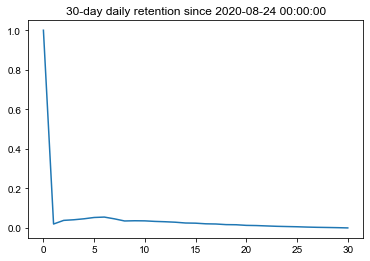

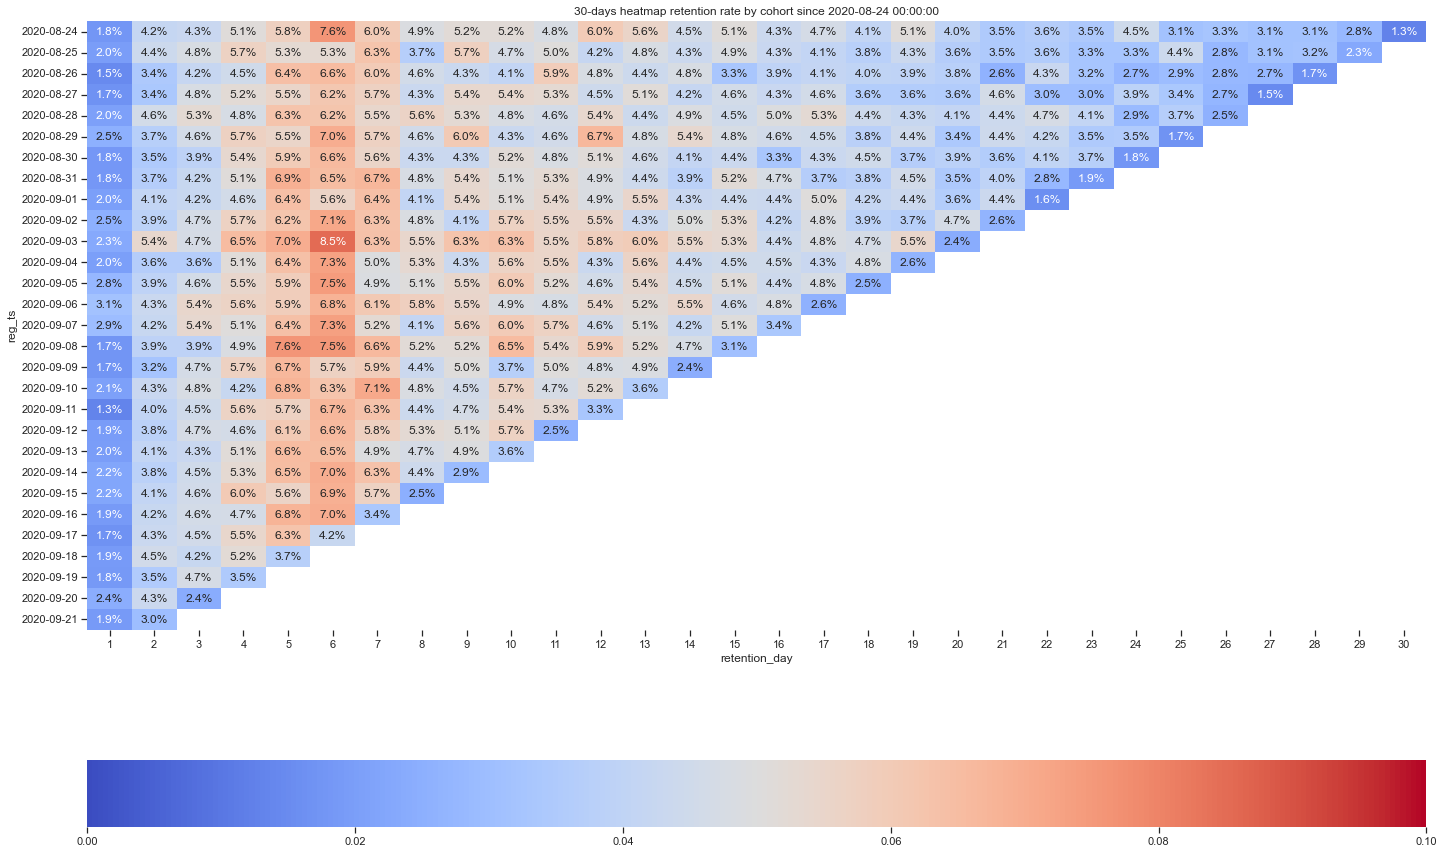

In [18]:
# Calculate retention for the last 30 days before the last recorded event
get_retention(df, 30, df.auth_ts.max() - pd.Timedelta(days=30))

C:\Users\pavel\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


retention_day
0     100.00
1       2.04
2       4.27
3       4.73
4       5.12
5       5.64
6       7.20
7       5.53
8       4.81
9       5.16
10      5.02
11      5.22
12      4.80
13      4.69
14      4.51
Name: uid, dtype: float64

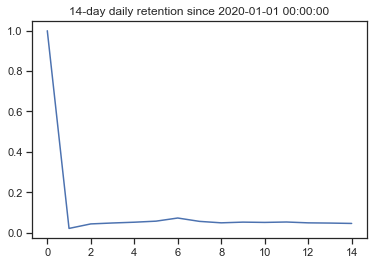

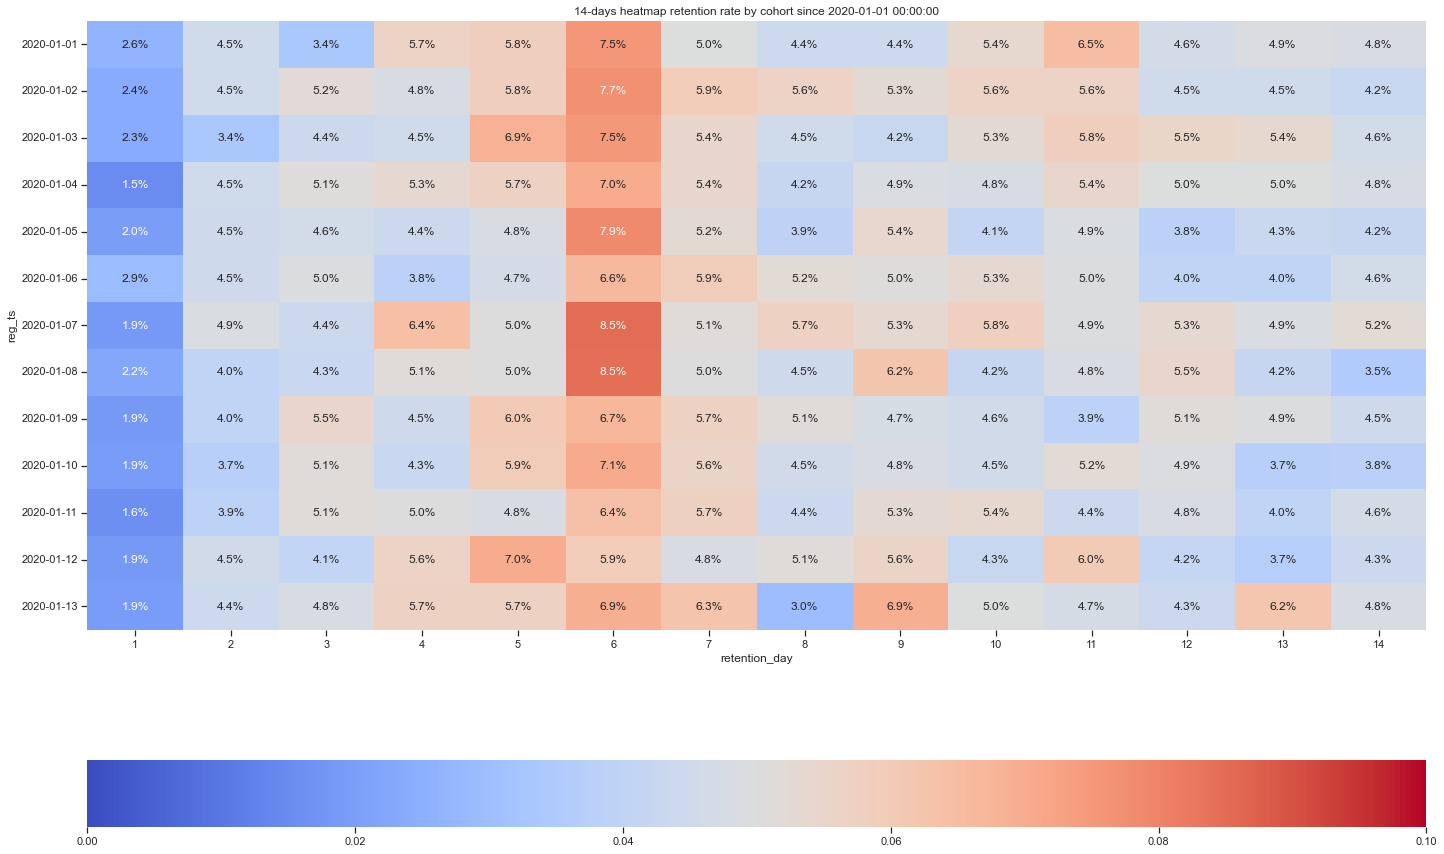

In [19]:
# Retention for a two-week period from January 1, 2020
get_retention(df, 14, '2020-01-01')